<a href="https://colab.research.google.com/github/armitaghobadi/Machine-Learning-and-Predictive-Modeling/blob/main/Speech_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# List all files and directories in the current directory
os.listdir('.')

['.config', 'sample_data']

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Specifying the file path:

In [3]:
file_path = '/content/drive/MyDrive/Speech.xlsx'


In [4]:
#importing libraries for data manipulation
import pandas as pd
import numpy as np

#import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import libraries for building linear regression models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import libraries for scaling data
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

file_path = '/content/drive/MyDrive/Speech.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows
df.head()


,SID,PROFICIENCY,SEX,CONTEXT,AMOUNT,DIVERSITY,COMPLEXITY
0,MN_2447,1,1,1,260,109,9.6
1,MN_2447,1,1,2,228,94,8.9
2,MN_5998,1,1,1,235,99,8.7
3,MN_5998,1,1,2,195,86,7.4
4,MN_1326,1,1,1,265,105,10.0


In [5]:
#let us check the percentage of missing values
df.isnull().sum()

,0
SID,0
PROFICIENCY,0
SEX,0
CONTEXT,0
AMOUNT,0
DIVERSITY,0
COMPLEXITY,0


No missing values whatsoever: all variables are integers


**EDA or Exploratory Data Analysis**

In [6]:
#analyzing/visualizing data one at a time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SID          132 non-null    object 
 1   PROFICIENCY  132 non-null    int64  
 2   SEX          132 non-null    int64  
 3   CONTEXT      132 non-null    int64  
 4   AMOUNT       132 non-null    int64  
 5   DIVERSITY    132 non-null    int64  
 6   COMPLEXITY   132 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 7.3+ KB


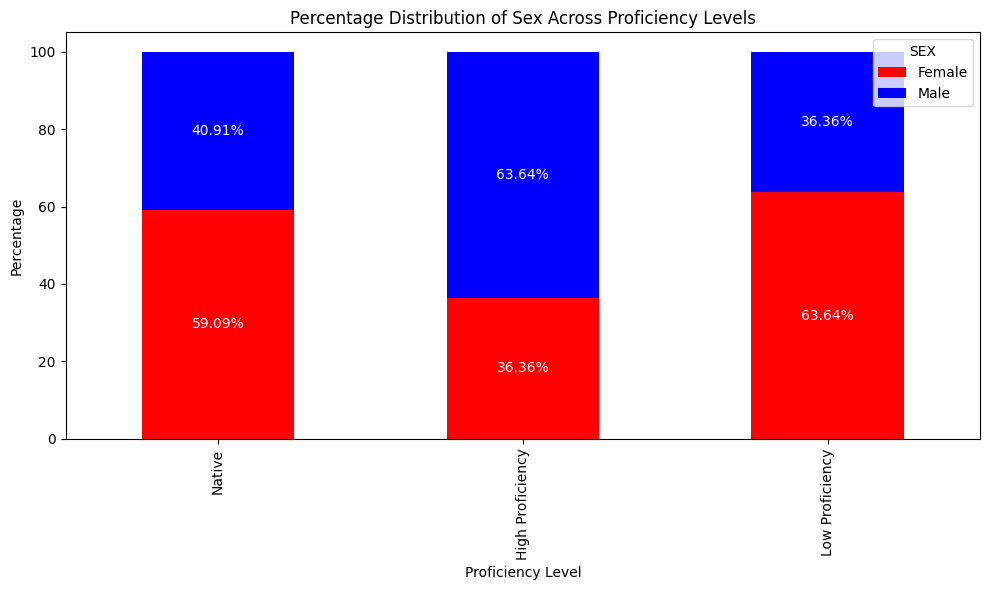

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a mapping dictionary for the categorical variables
proficiency_mapping = {1: 'Native', 2: 'High Proficiency', 3: 'Low Proficiency'}
sex_mapping = {1: 'Female', 2: 'Male'}

# Replace the numerical values with descriptive labels
df['PROFICIENCY'] = df['PROFICIENCY'].map(proficiency_mapping)
df['SEX'] = df['SEX'].map(sex_mapping)

# Calculate the percentage distribution of sex within each proficiency level
proficiency_sex_counts = df.groupby(['PROFICIENCY', 'SEX']).size().unstack(fill_value=0)
proficiency_sex_percentage = proficiency_sex_counts.div(proficiency_sex_counts.sum(axis=1), axis=0) * 100

# Reorder proficiency levels
proficiency_order = ['Native', 'High Proficiency', 'Low Proficiency']
proficiency_sex_percentage = proficiency_sex_percentage.loc[proficiency_order]

# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Use custom colors for Female and Male
colors = {'Female': 'red', 'Male': 'blue'}
proficiency_sex_percentage.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in proficiency_sex_percentage.columns])

# Set the labels and title
ax.set_xlabel('Proficiency Level')
ax.set_ylabel('Percentage')
ax.set_title('Percentage Distribution of Sex Across Proficiency Levels')

# Add percentage labels on the bars
for i, (index, row) in enumerate(proficiency_sex_percentage.iterrows()):
    cumulative_percentage = 0
    for sex, percentage in row.items():
        ax.text(i, cumulative_percentage + percentage / 2, f'{percentage:.2f}%',
                ha='center', va='center', color='white')
        cumulative_percentage += percentage

# Ensure that the x-axis has the correct order of proficiency levels
ax.set_xticklabels(proficiency_order)

plt.tight_layout()
plt.show()


**We have 22 people in each group for proficinecy variable (native, high, low). Sex variable is also normally distributed: 53% female in general and 47% males.**

In [ ]:
#let us do the same for the numerical variables
df.describe()

,CONTEXT,AMOUNT,DIVERSITY,COMPLEXITY
count,132.000000,132.000000,132.000000,132.000000
mean,1.500000,411.916667,138.333333,7.344318
std,0.501905,236.626257,47.586749,1.411128
min,1.000000,99.000000,51.000000,3.700000
25%,1.000000,255.500000,101.000000,6.300000
50%,1.500000,343.500000,131.000000,7.115000
75%,2.000000,487.750000,168.500000,8.225000
max,2.000000,1307.000000,320.000000,11.200000


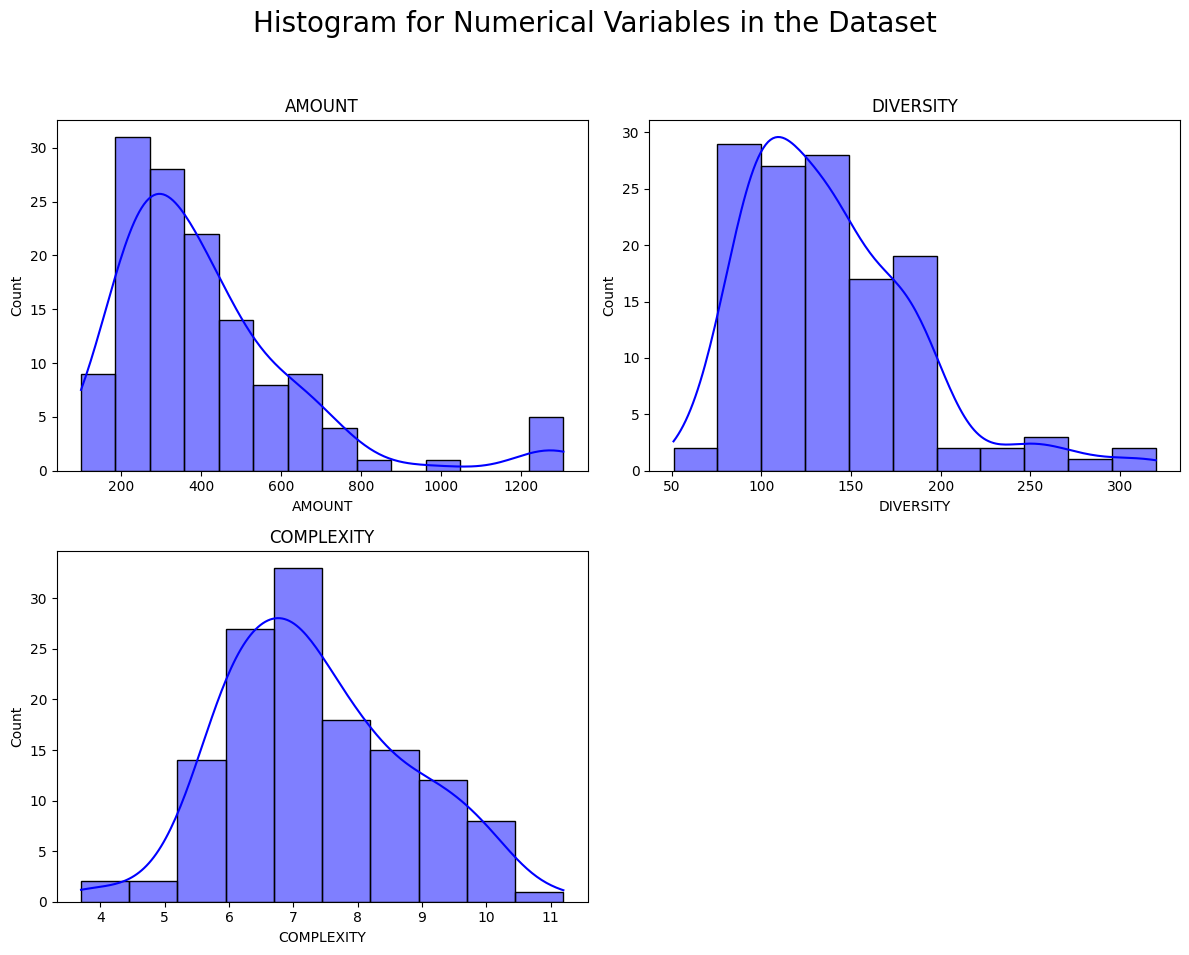

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing numerical variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid
fig.suptitle('Histogram for Numerical Variables in the Dataset', fontsize=20)

# Histogram for AMOUNT
sns.histplot(df['AMOUNT'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('AMOUNT')

# Histogram for DIVERSITY
sns.histplot(df['DIVERSITY'], kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set_title('DIVERSITY')

# Histogram for COMPLEXITY
sns.histplot(df['COMPLEXITY'], kde=True, ax=axes[1, 0], color='blue')
axes[1, 0].set_title('COMPLEXITY')

# Hide the unused subplot
axes[1, 1].axis('off')

# Adjust layout to fit the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Now it is the fun part: bivariate analysis**

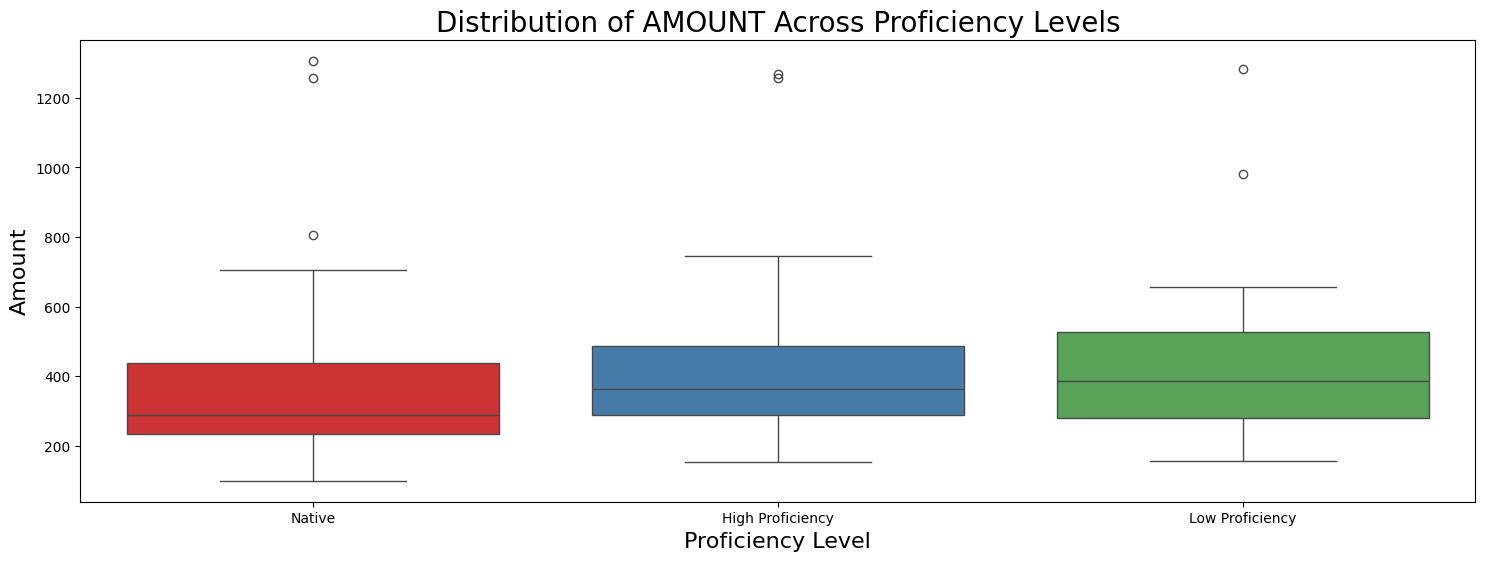

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig = plt.figure(figsize=(18, 6))

# Create a box plot to visualize the distribution of AMOUNT across different PROFICIENCY levels
sns.boxplot(x='PROFICIENCY', y='AMOUNT', data=df, palette='Set1')

# Set the title and labels
plt.title('Distribution of AMOUNT Across Proficiency Levels', fontsize=20)
plt.xlabel('Proficiency Level', fontsize=16)
plt.ylabel('Amount', fontsize=16)

# Show the plot
plt.show()

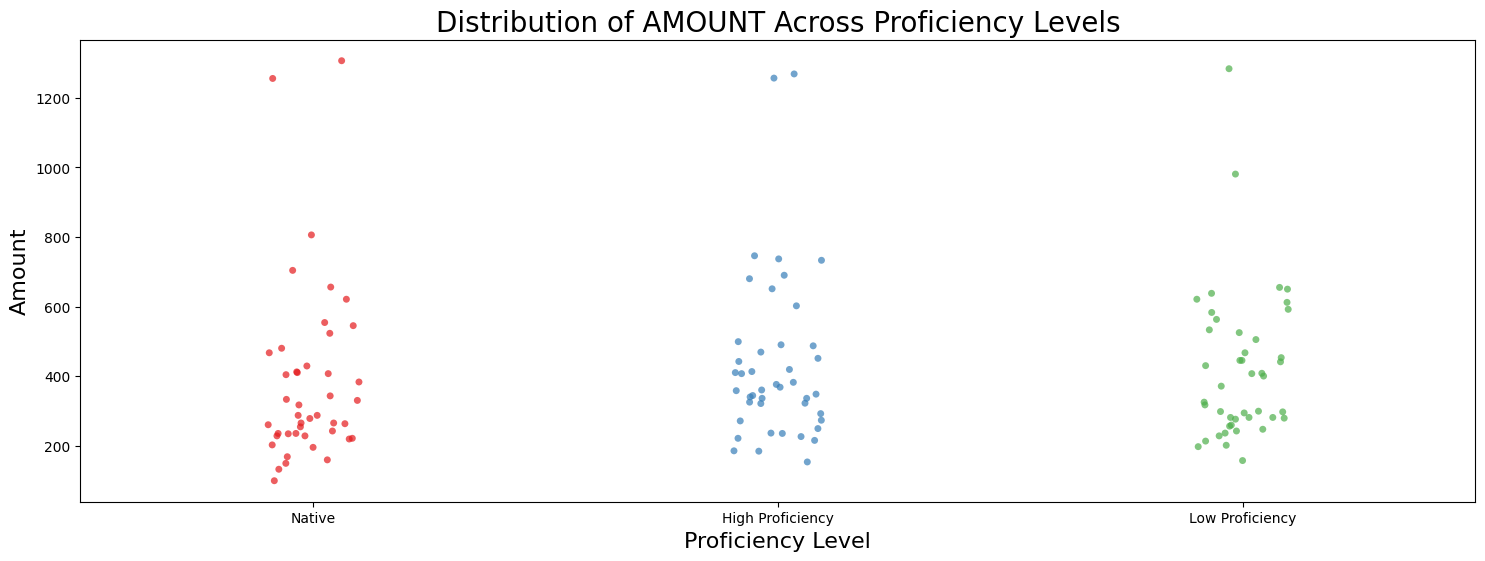

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig = plt.figure(figsize=(18, 6))

# Create a strip plot to visualize the distribution of AMOUNT across different PROFICIENCY levels
sns.stripplot(x='PROFICIENCY', y='AMOUNT', data=df, palette='Set1', jitter=True, alpha=0.7)

# Set the title and labels
plt.title('Distribution of AMOUNT Across Proficiency Levels', fontsize=20)
plt.xlabel('Proficiency Level', fontsize=16)
plt.ylabel('Amount', fontsize=16)

# Show the plot
plt.show()


**Boxplottting everything**

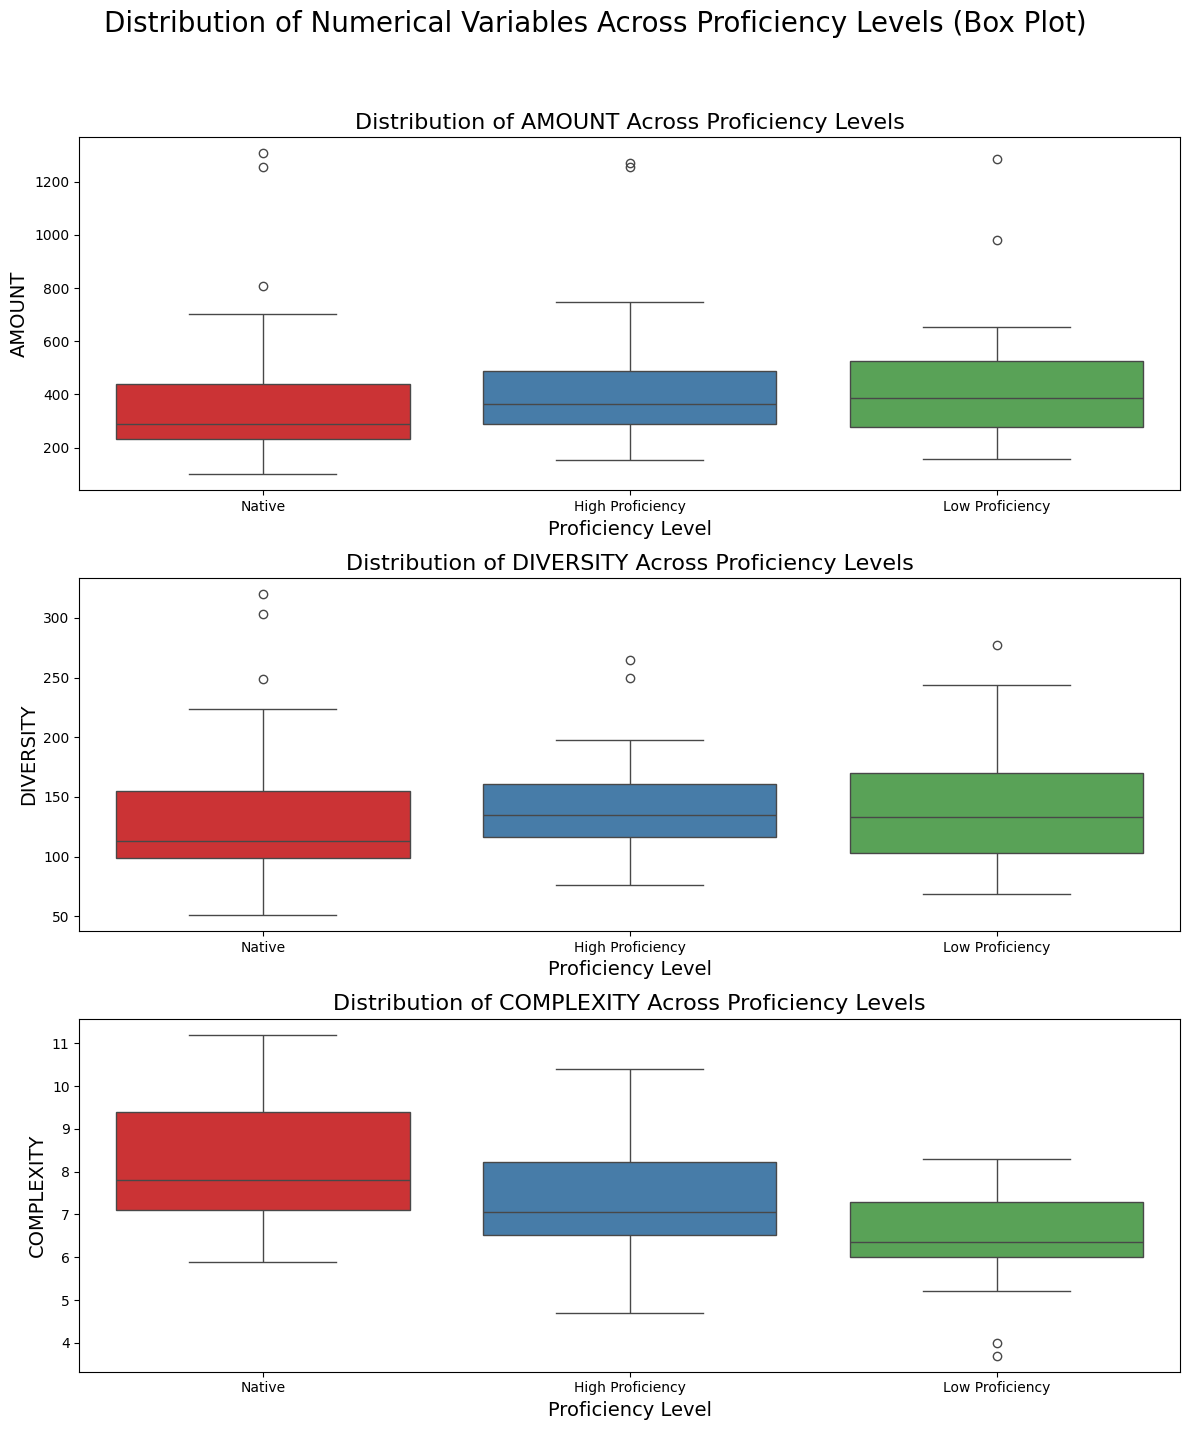

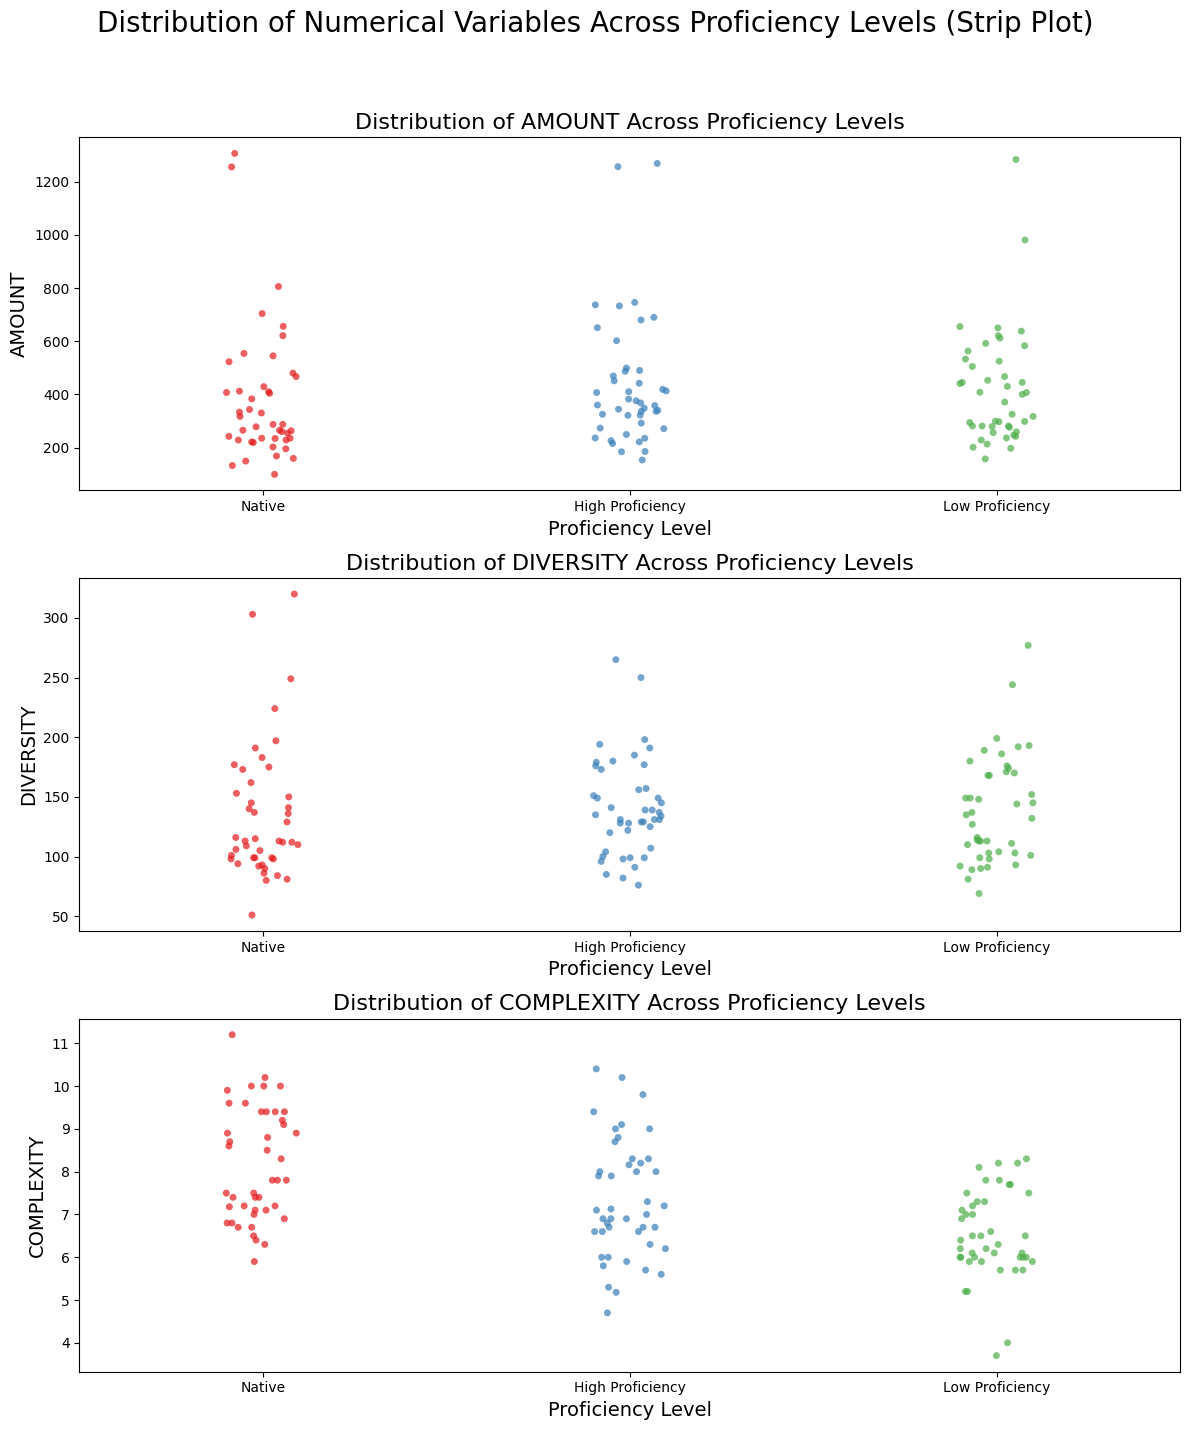

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical variables to plot
numerical_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Set up the figure for box plots
fig, axes = plt.subplots(len(numerical_vars), 1, figsize=(12, 5 * len(numerical_vars)))
fig.suptitle('Distribution of Numerical Variables Across Proficiency Levels (Box Plot)', fontsize=20)

for i, var in enumerate(numerical_vars):
    sns.boxplot(x='PROFICIENCY', y=var, data=df, palette='Set1', ax=axes[i])
    axes[i].set_title(f'Distribution of {var} Across Proficiency Levels', fontsize=16)
    axes[i].set_xlabel('Proficiency Level', fontsize=14)
    axes[i].set_ylabel(var, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Set up the figure for strip plots
fig, axes = plt.subplots(len(numerical_vars), 1, figsize=(12, 5 * len(numerical_vars)))
fig.suptitle('Distribution of Numerical Variables Across Proficiency Levels (Strip Plot)', fontsize=20)

for i, var in enumerate(numerical_vars):
    sns.stripplot(x='PROFICIENCY', y=var, data=df, palette='Set1', jitter=True, alpha=0.7, ax=axes[i])
    axes[i].set_title(f'Distribution of {var} Across Proficiency Levels', fontsize=16)
    axes[i].set_xlabel('Proficiency Level', fontsize=14)
    axes[i].set_ylabel(var, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

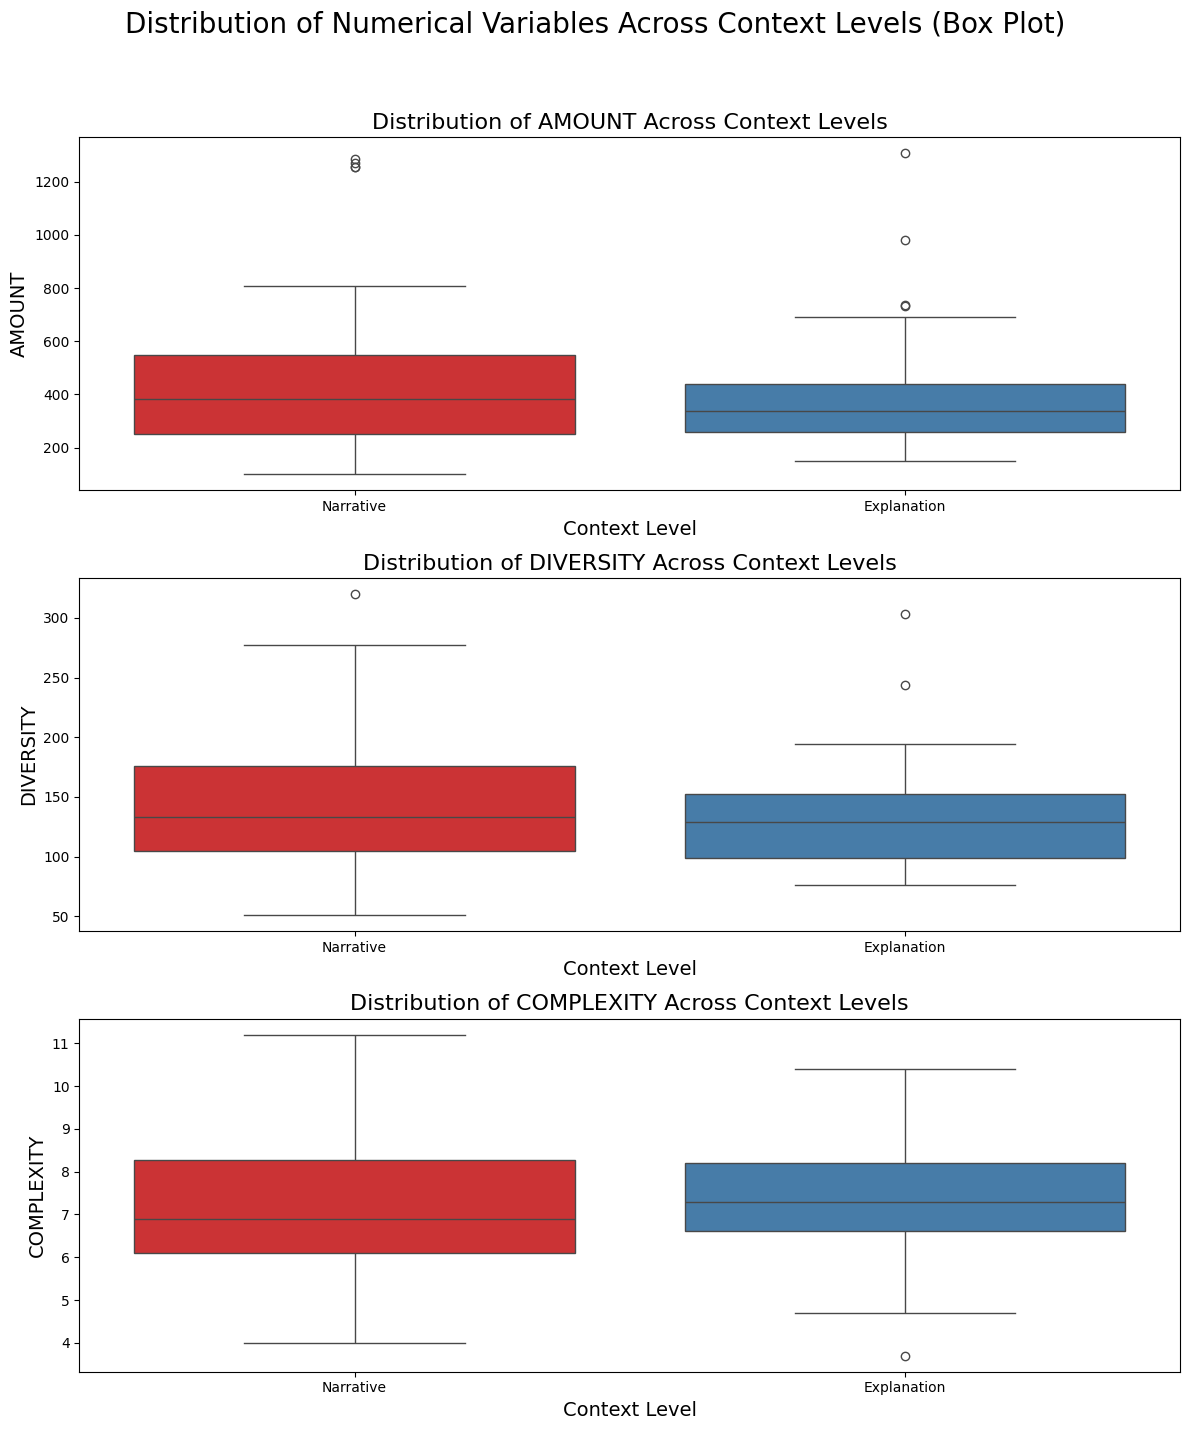

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert CONTEXT to categorical type with appropriate labels
df['CONTEXT'] = pd.Categorical(df['CONTEXT'], categories=[1, 2], ordered=True)
df['CONTEXT_LABEL'] = df['CONTEXT'].cat.rename_categories(['Narrative', 'Explanation'])

# List of numerical variables to plot
numerical_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']  # Update this list as needed

# Set up the figure for box plots
fig, axes = plt.subplots(len(numerical_vars), 1, figsize=(12, 5 * len(numerical_vars)))
fig.suptitle('Distribution of Numerical Variables Across Context Levels (Box Plot)', fontsize=20)

for i, var in enumerate(numerical_vars):
    sns.boxplot(x='CONTEXT_LABEL', y=var, data=df, palette='Set1', ax=axes[i])
    axes[i].set_title(f'Distribution of {var} Across Context Levels', fontsize=16)
    axes[i].set_xlabel('Context Level', fontsize=14)
    axes[i].set_ylabel(var, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


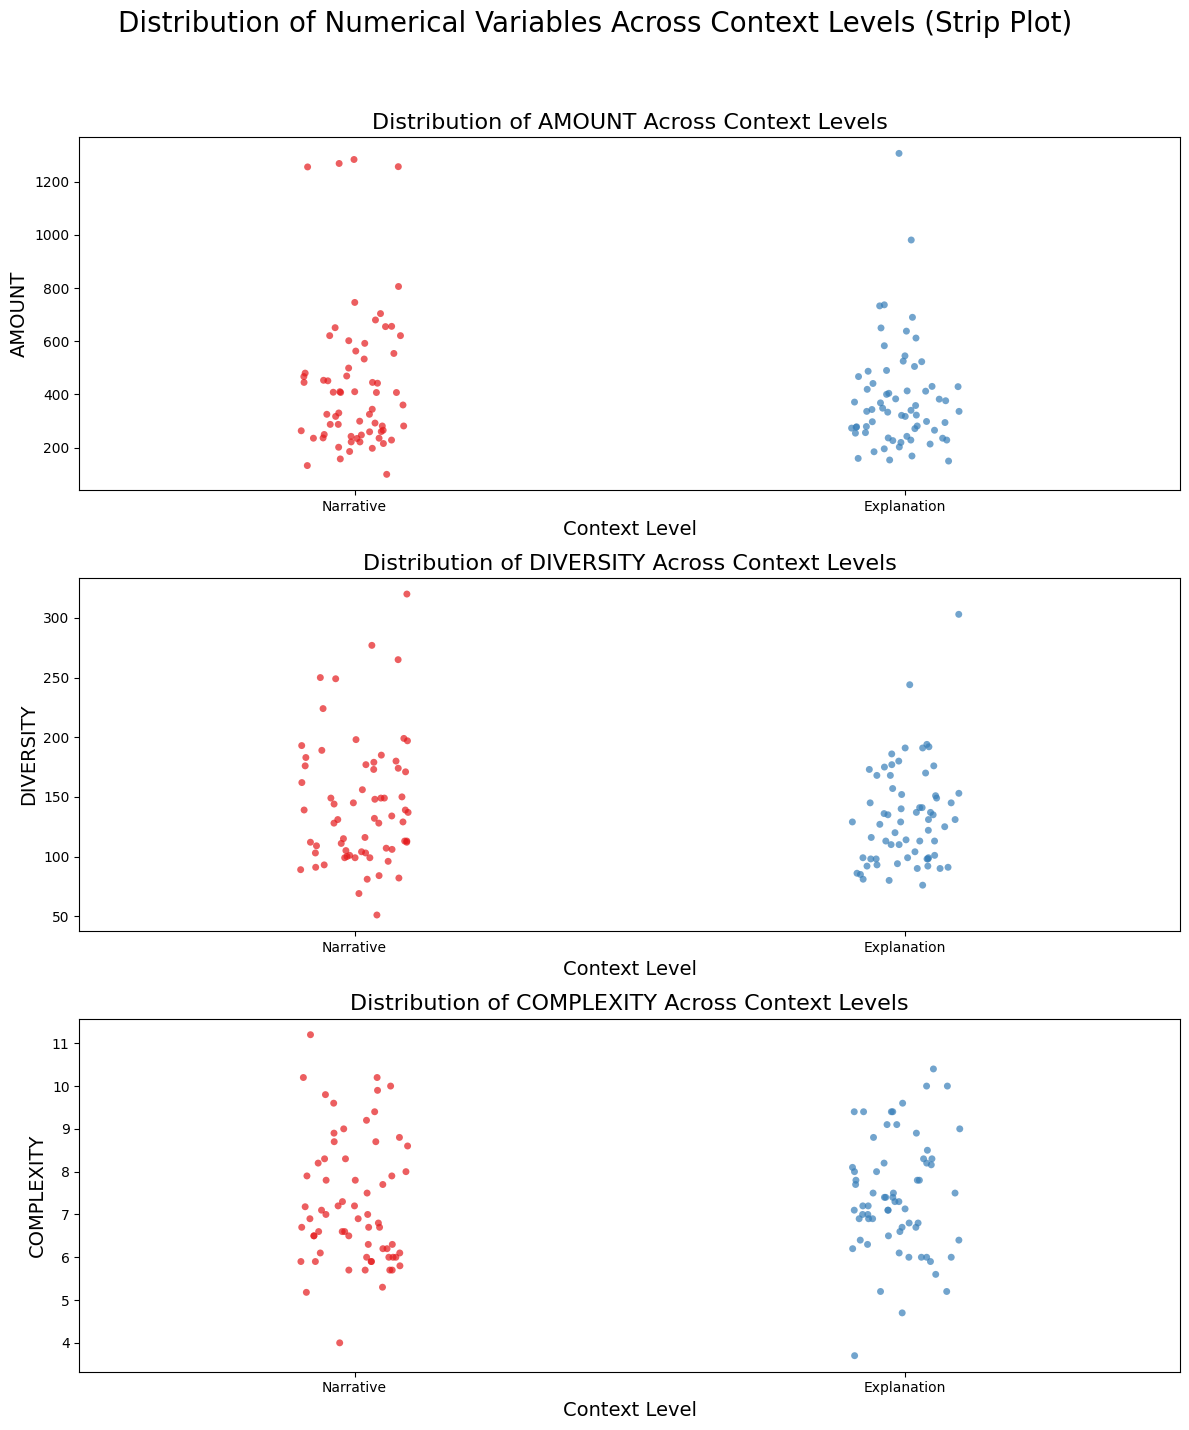

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert CONTEXT to categorical type with appropriate labels
df['CONTEXT'] = pd.Categorical(df['CONTEXT'], categories=[1, 2], ordered=True)
df['CONTEXT_LABEL'] = df['CONTEXT'].cat.rename_categories(['Narrative', 'Explanation'])

# List of numerical variables to plot
numerical_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']  # Update this list as needed

# Set up the figure for strip plots
fig, axes = plt.subplots(len(numerical_vars), 1, figsize=(12, 5 * len(numerical_vars)))
fig.suptitle('Distribution of Numerical Variables Across Context Levels (Strip Plot)', fontsize=20)

for i, var in enumerate(numerical_vars):
    sns.stripplot(x='CONTEXT_LABEL', y=var, data=df, palette='Set1', jitter=True, alpha=0.7, ax=axes[i])
    axes[i].set_title(f'Distribution of {var} Across Context Levels', fontsize=16)
    axes[i].set_xlabel('Context Level', fontsize=14)
    axes[i].set_ylabel(var, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


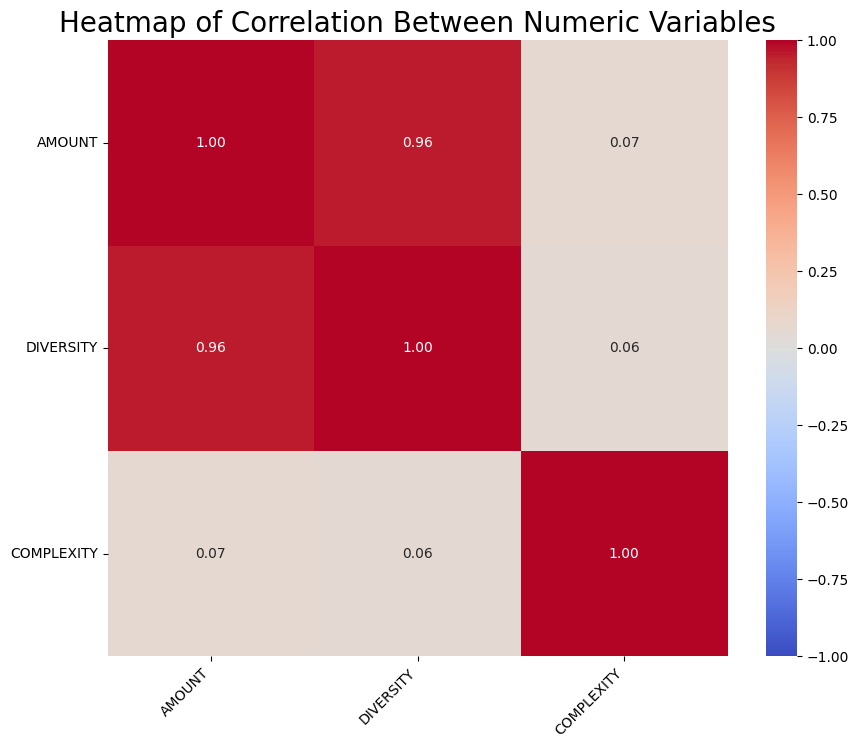

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric variables to include in the heatmap
variables = [
    'AMOUNT',
    'DIVERSITY',
    'COMPLEXITY'
]

# Subset the DataFrame to include only the relevant numeric variables
subset_df = df[variables]

# Calculate the correlation matrix
corr_matrix = subset_df.corr(numeric_only=True)

# Create the heatmap
fig = plt.figure(figsize=(10, 8))  # Adjusted figsize for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

plt.title('Heatmap of Correlation Between Numeric Variables', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Treating the outliers**

In [8]:
import pandas as pd

# Copy the original DataFrame to preserve it
df2 = df.copy()

# Define numerical columns to handle outliers
numerical_columns = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Replace outliers with the 5th and 95th percentiles
for column in numerical_columns:
    # Compute percentiles
    q_low = df2[column].quantile(0.05)
    q_hi  = df2[column].quantile(0.95)

    # Compute IQR
    q1 = df2[column].quantile(0.01)
    q3 = df2[column].quantile(0.99)
    iqr = q3 - q1

    # Replace outliers
    df2[column] = df2[column].apply(lambda x: q_low if x < q1 else (q_hi if x > q3 else x))

# Optionally, you can print the updated DataFrame statistics
print(df2[numerical_columns].describe())



            AMOUNT   DIVERSITY  COMPLEXITY
count   132.000000  132.000000  132.000000
mean    404.928788  137.493939    7.355833
std     213.331495   43.512674    1.332971
min     149.000000   76.000000    4.700000
25%     255.500000  101.000000    6.300000
50%     343.500000  131.000000    7.115000
75%     487.750000  168.500000    8.225000
max    1269.000000  277.000000   10.200000


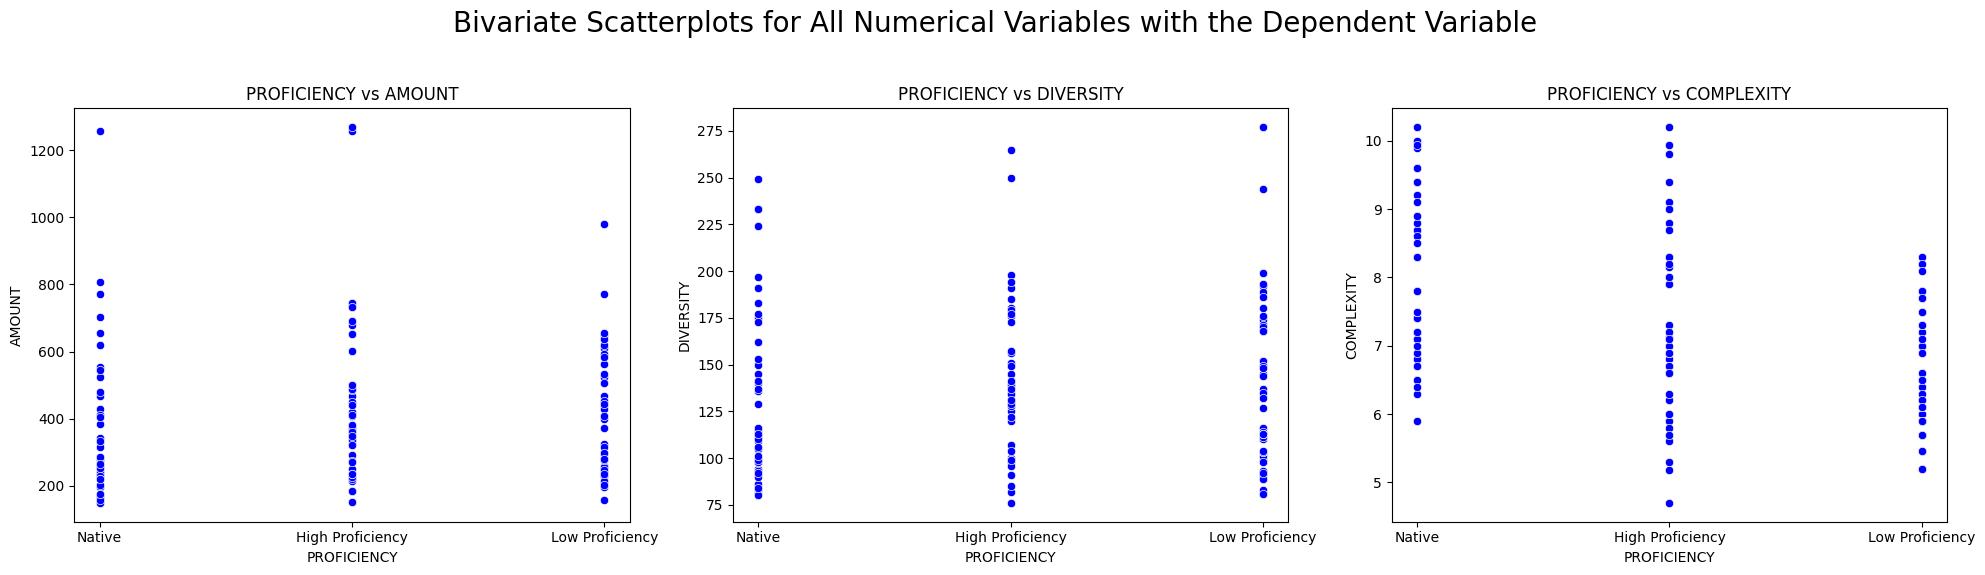

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of dependent variables for scatterplots
dependent_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Create subplots in a 1x3 grid
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 row, 3 columns
fig.suptitle('Bivariate Scatterplots for All Numerical Variables with the Dependent Variable', fontsize=20)

# Loop through each variable and create a scatterplot
for i, var in enumerate(dependent_vars):
    sns.scatterplot(data=df2, x='PROFICIENCY', y=var, ax=axes[i], color='blue')
    axes[i].set_title(f'PROFICIENCY vs {var}')
    axes[i].set_xlabel('PROFICIENCY')
    axes[i].set_ylabel(var)

# Adjust layout to fit the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




In [ ]:
# I cannot see any significant differences, let us look at the logic: before and after handling

print("Before Handling Outliers:")
print(df[numerical_columns].describe())

# Handle outliers (assuming the code above is applied here)

print("After Handling Outliers:")
print(df[numerical_columns].describe())


Before Handling Outliers:
            AMOUNT   DIVERSITY  COMPLEXITY
count   132.000000  132.000000  132.000000
mean    411.916667  138.333333    7.344318
std     236.626257   47.586749    1.411128
min      99.000000   51.000000    3.700000
25%     255.500000  101.000000    6.300000
50%     343.500000  131.000000    7.115000
75%     487.750000  168.500000    8.225000
max    1307.000000  320.000000   11.200000
After Handling Outliers:
            AMOUNT   DIVERSITY  COMPLEXITY
count   132.000000  132.000000  132.000000
mean    411.916667  138.333333    7.344318
std     236.626257   47.586749    1.411128
min      99.000000   51.000000    3.700000
25%     255.500000  101.000000    6.300000
50%     343.500000  131.000000    7.115000
75%     487.750000  168.500000    8.225000
max    1307.000000  320.000000   11.200000


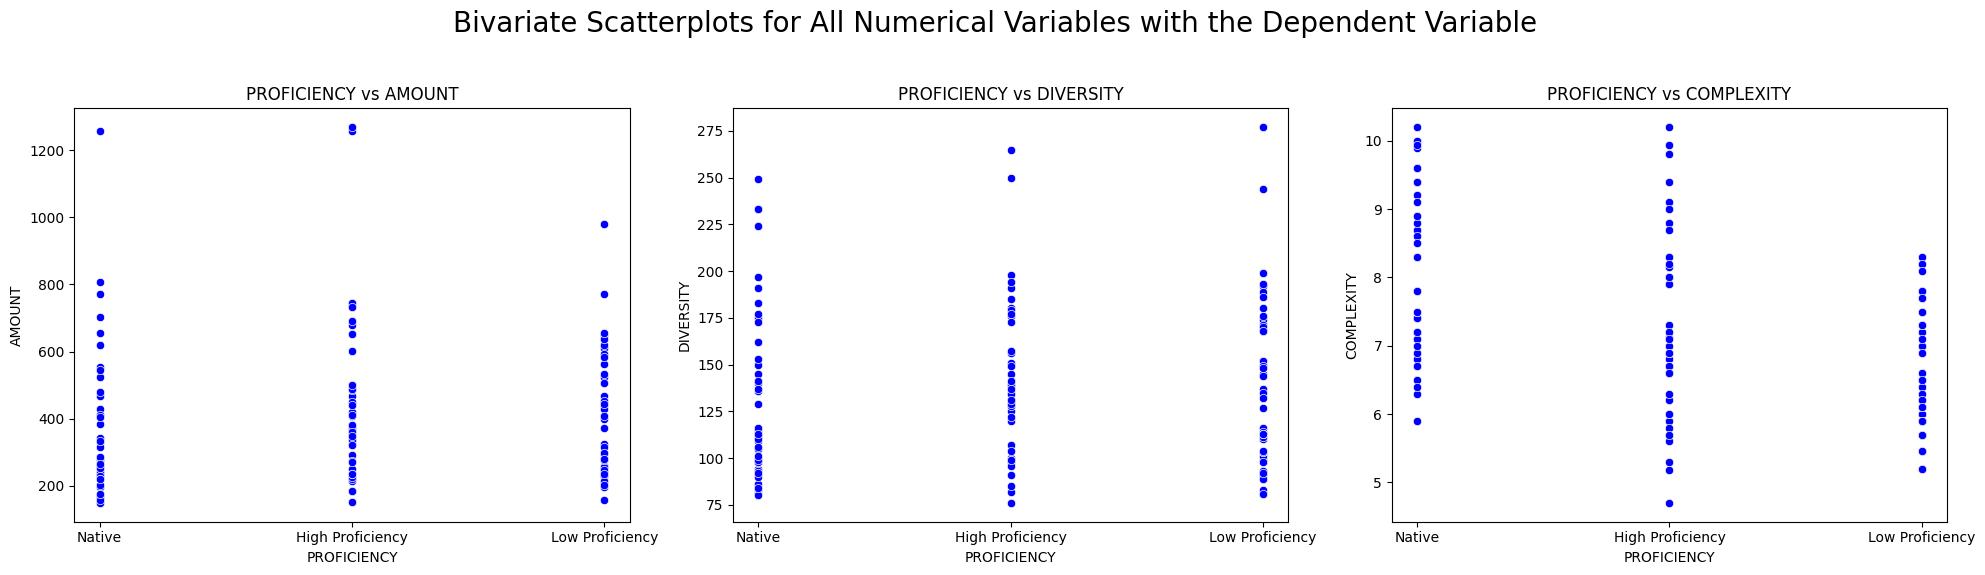

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of dependent variables for scatterplots
dependent_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Create subplots in a 1x3 grid (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Bivariate Scatterplots for All Numerical Variables with the Dependent Variable', fontsize=20)

# Loop through each variable and create a scatterplot
for i, var in enumerate(dependent_vars):
    sns.scatterplot(data=df2, x='PROFICIENCY', y=var, ax=axes[i], color='blue')
    axes[i].set_title(f'PROFICIENCY vs {var}')
    axes[i].set_xlabel('PROFICIENCY')
    axes[i].set_ylabel(var)

# Adjust layout to fit the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**It seems to be handled**

**I am standardizing the data to be able to compare variables together**

In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the columns to be standardized
columns_to_standardize = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Initialize the StandardScaler
scaler = StandardScaler()

# Create a copy of df2 to store the standardized data
df3 = df2.copy()

# Apply standardization to the specified columns
df3[columns_to_standardize] = scaler.fit_transform(df2[columns_to_standardize])

# Optionally, you can check the first few rows of the new DataFrame
print(df3.head())


       SID PROFICIENCY     SEX  CONTEXT    AMOUNT  DIVERSITY  COMPLEXITY
0  MN_2447      Native  Female        1 -0.681948  -0.657337    1.689996
1  MN_2447      Native  Female        2 -0.832520  -1.003377    1.162853
2  MN_5998      Native  Female        1 -0.799583  -0.888031    1.012241
3  MN_5998      Native  Female        2 -0.987798  -1.187932    0.033260
4  MN_1326      Native  Female        1 -0.658421  -0.749614    1.991221


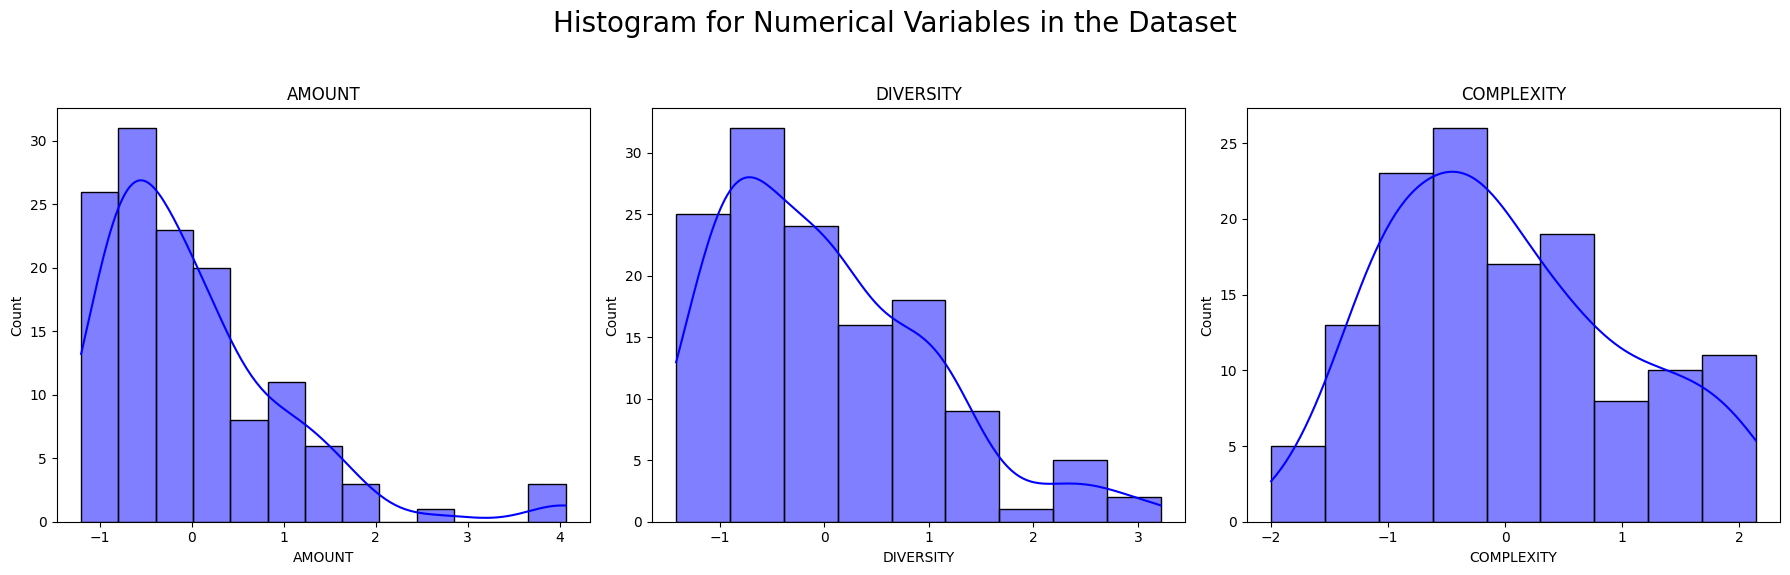

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing numerical variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Histogram for Numerical Variables in the Dataset', fontsize=20)

# Histogram for AMOUNT
sns.histplot(df3['AMOUNT'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('AMOUNT')

# Histogram for DIVERSITY
sns.histplot(df3['DIVERSITY'], kde=True, ax=axes[1], color='blue')
axes[1].set_title('DIVERSITY')

# Histogram for COMPLEXITY
sns.histplot(df3['COMPLEXITY'], kde=True, ax=axes[2], color='blue')
axes[2].set_title('COMPLEXITY')

# Adjust layout to fit the suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**DF3 is standardized**

In [11]:
df3.columns

Index(['SID', 'PROFICIENCY', 'SEX', 'CONTEXT', 'AMOUNT', 'DIVERSITY',
       'COMPLEXITY'],
      dtype='object')

In [ ]:
import pandas as pd

# Perform one-hot encoding without drop_first to manually control which columns to drop
df3_encoded = pd.get_dummies(df3, columns=['PROFICIENCY'])

# Drop the 'PROFICIENCY_Native' column manually
df3_encoded.drop(columns=['PROFICIENCY_Native'], inplace=True)

# Rename the remaining columns to ensure correct names
df3_encoded.rename(columns={
    'PROFICIENCY_High Proficiency': 'PROFICIENCY_High_Proficiency',
    'PROFICIENCY_Low Proficiency': 'PROFICIENCY_Low_Proficiency'
}, inplace=True)

# Print the DataFrame and columns to verify
print(df3_encoded.head())
print(df3_encoded.columns)


       SID     SEX CONTEXT    AMOUNT  DIVERSITY  COMPLEXITY CONTEXT_LABEL  \
0  MN_2447  Female       1 -0.681948  -0.657337    1.689996     Narrative   
1  MN_2447  Female       2 -0.832520  -1.003377    1.162853   Explanation   
2  MN_5998  Female       1 -0.799583  -0.888031    1.012241     Narrative   
3  MN_5998  Female       2 -0.987798  -1.187932    0.033260   Explanation   
4  MN_1326  Female       1 -0.658421  -0.749614    1.991221     Narrative   

   PROFICIENCY_High_Proficiency  PROFICIENCY_Low_Proficiency  
0                         False                        False  
1                         False                        False  
2                         False                        False  
3                         False                        False  
4                         False                        False  
Index(['SID', 'SEX', 'CONTEXT', 'AMOUNT', 'DIVERSITY', 'COMPLEXITY',
       'CONTEXT_LABEL', 'PROFICIENCY_High_Proficiency',
       'PROFICIENCY_Low_Proficienc

In [ ]:
#creating a new dataset df2 in which one-hot encoding will drop NATIVE as baseline.

In [ ]:
df3_encoded.head()

,SID,SEX,CONTEXT,AMOUNT,DIVERSITY,COMPLEXITY,CONTEXT_LABEL,PROFICIENCY_High_Proficiency,PROFICIENCY_Low_Proficiency
0,MN_2447,Female,1,-0.681948,-0.657337,1.689996,Narrative,False,False
1,MN_2447,Female,2,-0.832520,-1.003377,1.162853,Explanation,False,False
2,MN_5998,Female,1,-0.799583,-0.888031,1.012241,Narrative,False,False
3,MN_5998,Female,2,-0.987798,-1.187932,0.033260,Explanation,False,False
4,MN_1326,Female,1,-0.658421,-0.749614,1.991221,Narrative,False,False


Now it is the time to do the **Regression Model**!




** GLMM is one of the good choices as our data is somehow nested (they went through two tasks, counterbalanced order*** **bold text**


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# List of dependent variables
dependent_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Loop through each dependent variable
for dv in dependent_vars:
    # Create the formula for GLMM with interaction terms between CONTEXT and PROFICIENCY variables
    formula = f'{dv} ~ CONTEXT * PROFICIENCY_High_Proficiency + CONTEXT * PROFICIENCY_Low_Proficiency'

    # Fit the GLMM model with a random effect for SID
    model = smf.mixedlm(formula, df3_encoded, groups=df3_encoded["SID"]).fit()

    # Print the summary of the regression results
    print(f'Regression results for {dv}:')
    print(model.summary())
    print("\n" + "="*80 + "\n")


Regression results for AMOUNT:
                           Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             AMOUNT   
No. Observations:              132                 Method:                         REML     
No. Groups:                    66                  Scale:                          0.3572   
Min. group size:               2                   Log-Likelihood:                 -171.3143
Max. group size:               2                   Converged:                      Yes      
Mean group size:               2.0                                                          
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          0.057    0.213  

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# List of dependent variables
dependent_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Loop through each dependent variable
for dv in dependent_vars:
    # Create the formula for GLMM with all main effects and interaction terms
    formula = f'{dv} ~ SEX * CONTEXT + SEX * PROFICIENCY_High_Proficiency + SEX * PROFICIENCY_Low_Proficiency + CONTEXT * PROFICIENCY_High_Proficiency + CONTEXT * PROFICIENCY_Low_Proficiency'

    # Fit the GLMM model with a random effect for SID
    model = smf.mixedlm(formula, df3_encoded, groups=df3_encoded["SID"]).fit()

    # Print the summary of the regression results
    print(f'Regression results for {dv}:')
    print(model.summary())
    print("\n" + "="*80 + "\n")


Regression results for AMOUNT:
                           Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             AMOUNT   
No. Observations:              132                 Method:                         REML     
No. Groups:                    66                  Scale:                          0.3614   
Min. group size:               2                   Log-Likelihood:                 -171.3636
Max. group size:               2                   Converged:                      Yes      
Mean group size:               2.0                                                          
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                         -0.075    0.275 -

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit the model
for dv in dependent_vars:
    formula = (f'{dv} ~ SEX + CONTEXT * PROFICIENCY_High_Proficiency + '
               f'CONTEXT * PROFICIENCY_Low_Proficiency')

    model = smf.mixedlm(formula, df3_encoded, groups=df3_encoded["SID"]).fit()

    # Print the summary to understand coefficient names and order
    print(model.summary())


                           Mixed Linear Model Regression Results
Model:                         MixedLM             Dependent Variable:             AMOUNT   
No. Observations:              132                 Method:                         REML     
No. Groups:                    66                  Scale:                          0.3572   
Min. group size:               2                   Log-Likelihood:                 -171.7030
Max. group size:               2                   Converged:                      Yes      
Mean group size:               2.0                                                          
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          0.004    0.234  0.016 0.987 -0.455  0.463
SEX[T

**This is only for comparing high vs. low**

In [14]:
import pandas as pd

# Perform one-hot encoding on the 'PROFICIENCY' column without drop_first
df5 = pd.get_dummies(df3, columns=['PROFICIENCY'])

# Print the column names to verify
print(df5.columns)


Index(['SID', 'SEX', 'CONTEXT', 'AMOUNT', 'DIVERSITY', 'COMPLEXITY',
       'PROFICIENCY_High Proficiency', 'PROFICIENCY_Low Proficiency',
       'PROFICIENCY_Native'],
      dtype='object')


In [15]:
import pandas as pd

# Perform one-hot encoding on the 'PROFICIENCY' column without drop_first
df5 = pd.get_dummies(df3, columns=['PROFICIENCY'])

# Drop the 'PROFICIENCY_High Proficiency' column to set it as the baseline
df5.drop(columns=['PROFICIENCY_High Proficiency'], inplace=True)

# Rename the remaining columns for clarity
df5.rename(columns={
    'PROFICIENCY_Native': 'PROFICIENCY_Native',
    'PROFICIENCY_Low Proficiency': 'PROFICIENCY_Low'
}, inplace=True)

# Print the DataFrame and columns to verify
print(df5.head())
print(df5.columns)


       SID     SEX  CONTEXT    AMOUNT  DIVERSITY  COMPLEXITY  PROFICIENCY_Low  \
0  MN_2447  Female        1 -0.681948  -0.657337    1.689996            False   
1  MN_2447  Female        2 -0.832520  -1.003377    1.162853            False   
2  MN_5998  Female        1 -0.799583  -0.888031    1.012241            False   
3  MN_5998  Female        2 -0.987798  -1.187932    0.033260            False   
4  MN_1326  Female        1 -0.658421  -0.749614    1.991221            False   

   PROFICIENCY_Native  
0                True  
1                True  
2                True  
3                True  
4                True  
Index(['SID', 'SEX', 'CONTEXT', 'AMOUNT', 'DIVERSITY', 'COMPLEXITY',
       'PROFICIENCY_Low', 'PROFICIENCY_Native'],
      dtype='object')




> The baseline is HIGH proficiency



In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# List of dependent variables
dependent_vars = ['AMOUNT', 'DIVERSITY', 'COMPLEXITY']

# Loop through each dependent variable
for dv in dependent_vars:
    # Create the formula for GLMM with all main effects and interaction terms, excluding SEX
    formula = f'{dv} ~ CONTEXT * PROFICIENCY_Native + CONTEXT * PROFICIENCY_Low'

    # Fit the GLMM model with a random effect for SID
    model = smf.mixedlm(formula, df5, groups=df5["SID"]).fit()

    # Print the summary of the regression results
    print(f'Regression results for {dv}:')
    print(model.summary())
    print("\n" + "="*80 + "\n")


Regression results for AMOUNT:
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        AMOUNT   
No. Observations:         132            Method:                    REML     
No. Groups:               66             Scale:                     0.3572   
Min. group size:          2              Log-Likelihood:            -171.3143
Max. group size:          2              Converged:                 Yes      
Mean group size:          2.0                                                
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.774    0.332  2.329 0.020  0.123  1.425
PROFICIENCY_Native[T.True]         -0.296    0.470 -0.630 0.529 -1.217  0.625
PROFICIENCY_Low[T.True]            -0.842    0.470 -1